# Statistics for sentiment score

In this notebook we perform an analysis with the sentiment score saved in our dataset.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import config
from paths import Paths

channel_paths = Paths(channel_handle=config.channel_handle)

### Working with pandas, seamless interoperability with plotting libraries

In [3]:
cols = ['video_id', 'comment_id', 'parent_id', 'comment_length', 'word_count', 'is_reply', 'emoji_count', 'published_at', 'lang', 'sentiment_score', 'reply_count']
df = pd.concat([pd.read_parquet(file, columns=cols) for file in channel_paths.list_processed_files()])

### English only data
This is where the taks of language detection comes in place, since VADER sentiment analyser doesn't work with languages other than english, we will work with english only.

Let's review the percentage of languages present in our dataset according to our language detector.

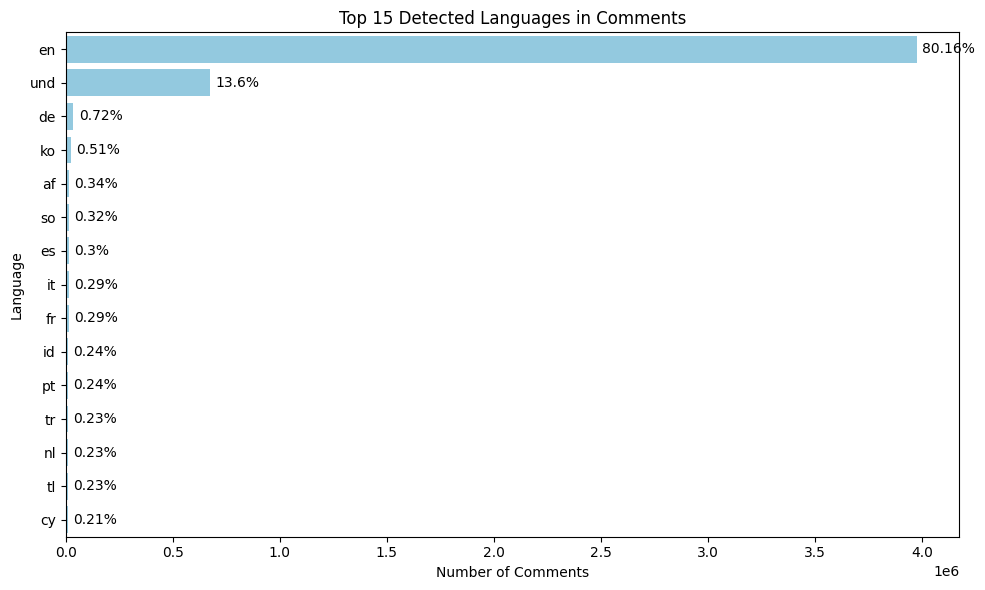

In [4]:
# Count language frequencies
lang_counts = df['lang'].value_counts()
total_comments = lang_counts.sum()

# Compute percentages
lang_percentages = (lang_counts / total_comments * 100).round(2)
lang_df = pd.DataFrame({
    'language': lang_percentages.index,
    'percentage': lang_percentages.values,
    'count': lang_counts.values
}).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=lang_df,
    y='language',
    x='count',
    color='skyblue'  # avoids palette warning
)

# Annotate percentages next to bars
for index, row in lang_df.iterrows():
    plt.text(row['count'] + total_comments * 0.005, index, f"{row['percentage']}%", va='center')

plt.title("Top 15 Detected Languages in Comments")
plt.xlabel("Number of Comments")
plt.ylabel("Language")
plt.tight_layout()
plt.show()

# NOTE: We cannot draw any definitive conclusions from this notebook's results

While it is useful to highlight the capabilities, and the possiblities of working with sentiment scores, there may be oversights that this project doesn't account for:
- The data is not up to date all the time.
- The presence of bots or spammers could bias our results.
- The quality of language detection should be highly scrutinized.
- Similarly, the task of sentiment analysis should be done with carefulness, evaluating the performance of the model for reliability.
- The variables should be understoond more thoroughly, to determine what counts for outlier, do we include emojis? do we include mentions? do we filter out comments less than certain length?
- There are statistical tools to draw conclusions from seemingly random data.

Of the previous points little is done in this project, the task of sentiment analysis is a project on itself so the results here are purely informational/exploratory and not definitive or conclusory.

# NOTE 2: About negative comments

A comment labeled as negative is not necessarily toxic, or ill intended. We are reviewing data from the YouTube channel: Kurzgesagt In a Nutshell, channel where some of the topics include Virus, Bomb, War, Cander, but in a informative way. VADER sentiment analyser doesn't account for the context of a comment, for example:

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("The rates of lung cancer have decreased over the past decade.")

{'neg': 0.306, 'neu': 0.694, 'pos': 0.0, 'compound': -0.6597}

We are working with the "compound" score, it shows a value of -0.6597 (we categorize it as negative), when the comment is clearly a positive thing. Similarly, words like:
- Cancer
- Bomb
- War
- Virus
- Nuke
Topics frequented in the channel would get flagged as negative, regardless of the context.
This is a pitfall to account for when looking at the data:
## Negative ≠ Toxic

### English only data

In [5]:
df = df[df['lang'] == 'en'].copy()

### Normalized distribution of sentiment scores

Neutral comments are a significant portion of all comments, positive and negative comments have a smaller proportion, with positive comments having slight more representation.

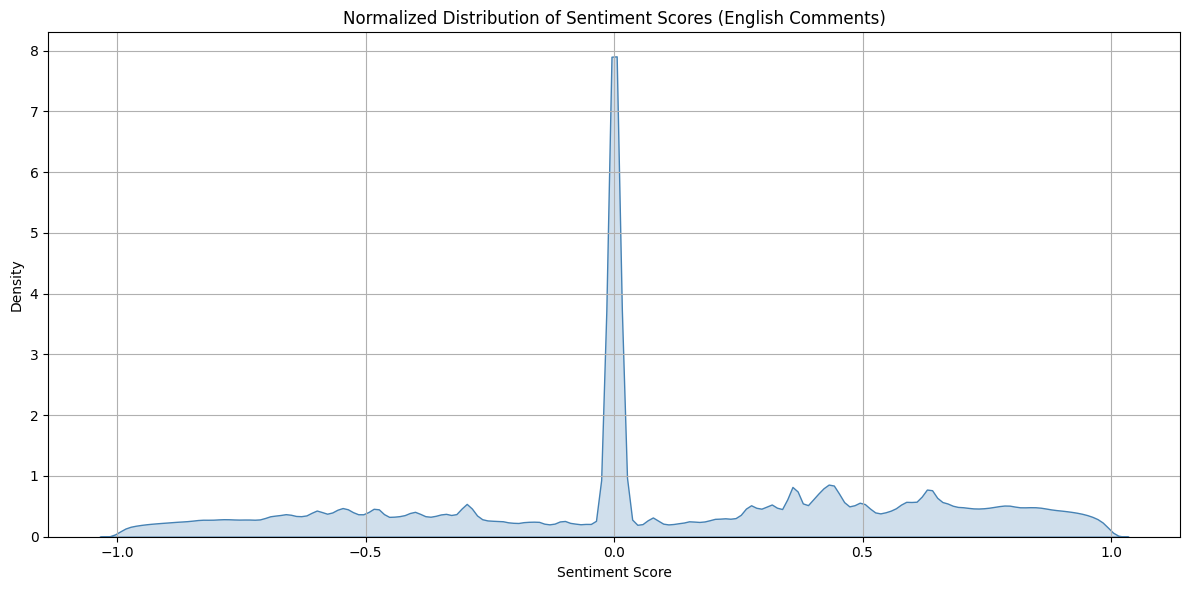

In [6]:
# Plot
plt.figure(figsize=(12, 6))

# Plot KDE of sentiment scores
sns.kdeplot(df['sentiment_score'], bw_adjust=0.5, fill=True, color='steelblue')

plt.title("Normalized Distribution of Sentiment Scores (English Comments)")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

### Sepparating the sentminent score by bins
The sentiment score from VADER comes from -1 to 1, where -1 is the most negative and 1 is the most positive, so we create categories from this scoring:
| Range             | Sentiment               |
|------------------|-------------------------|
| -1 to -0.75      | Overwhelmingly Negative |
| -0.75 to -0.5    | Very Negative           |
| -0.5 to -0.25    | Mostly Negative         |
| -0.25 to -0.05   | Negative                |
| -0.05 to 0.05    | Neutral                 |
| 0.05 to 0.25     | Positive                |
| 0.25 to 0.5      | Mostly Positive         |
| 0.5 to 0.75      | Very Positive           |
| 0.75 to 1        | Overwhelmingly Positive |

When binned, the proportion of neutral is still high, but the positive comments have a more visible proportion, specially against negative comments.

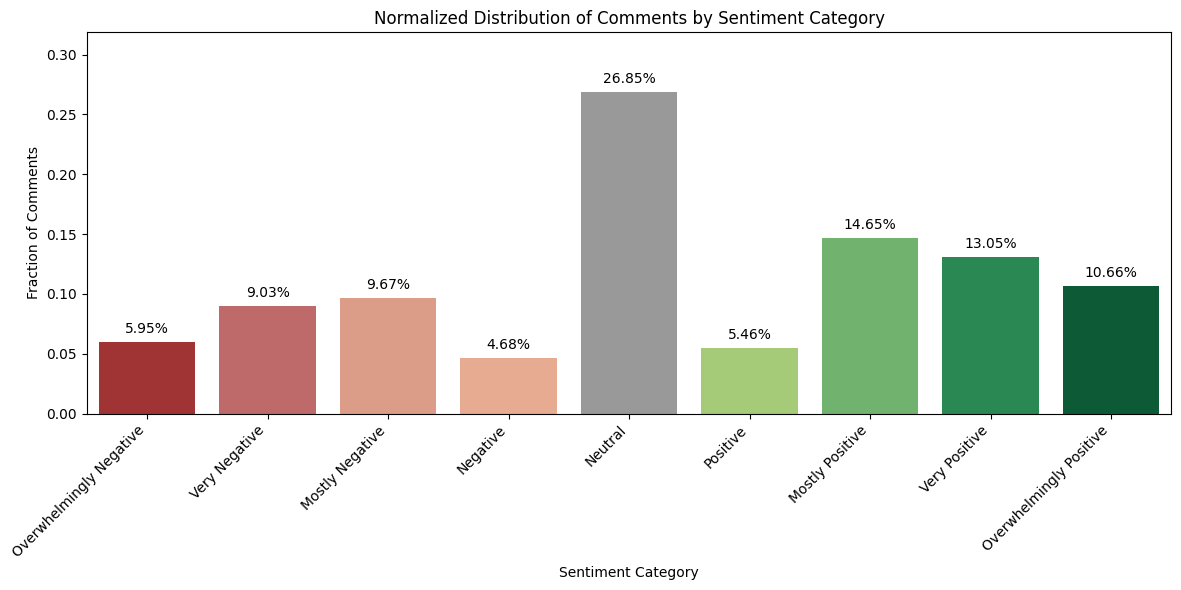

In [22]:
# Sentiment bins and labels
bins = [-1, -0.75, -0.5, -0.25, -0.05, 0.05, 0.25, 0.5, 0.75, 1]
labels = [
    "Overwhelmingly Negative",
    "Very Negative",
    "Mostly Negative",
    "Negative",
    "Neutral",
    "Positive",
    "Mostly Positive",
    "Very Positive",
    "Overwhelmingly Positive"
]

df['sentiment_category'] = pd.cut(df['sentiment_score'], bins=bins, labels=labels, include_lowest=True)

cat_counts = df['sentiment_category'].value_counts(normalize=True).reindex(labels)

# Define color mapping: reds for negative, green for positive, gray for neutral
color_map = {
    "Overwhelmingly Negative": "#b22222",  # firebrick red
    "Very Negative": "#cd5c5c",            # indian red
    "Mostly Negative": "#e9967a",           # dark salmon
    "Negative": "#f4a582",                   # lighter red/orange
    "Neutral": "#999999",                    # gray
    "Positive": "#a6d96a",                   # light green
    "Mostly Positive": "#66bd63",            # medium green
    "Very Positive": "#1a9850",              # strong green
    "Overwhelmingly Positive": "#006837"    # dark green
}

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=cat_counts.index,
    y=cat_counts.values,
    hue=cat_counts.index,
    palette=color_map,
    legend=False
)

# Add labels above bars
for i, val in enumerate(cat_counts.values):
    ax.text(i, val + 0.005, f"{val:.2%}", ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.title("Normalized Distribution of Comments by Sentiment Category")
plt.ylabel("Fraction of Comments")
plt.xlabel("Sentiment Category")
plt.ylim(0, max(cat_counts.values) + 0.05)
plt.tight_layout()
plt.show()

### Share of replies by sentiment category

From the statistics notebook we saw that the replies were about a third of all comments. But, what about sentiment category? Turns out that negative categories tend to have a higher share of replies, sometimes as little under half of the overwhelmingly negative comments are only replies.

The trend at neutral shows a similar metric to the one we got in the previous analysis of comments.

Overall, there is a decrease of share of replies per sentiment category as the sentiment score of the comment increases.

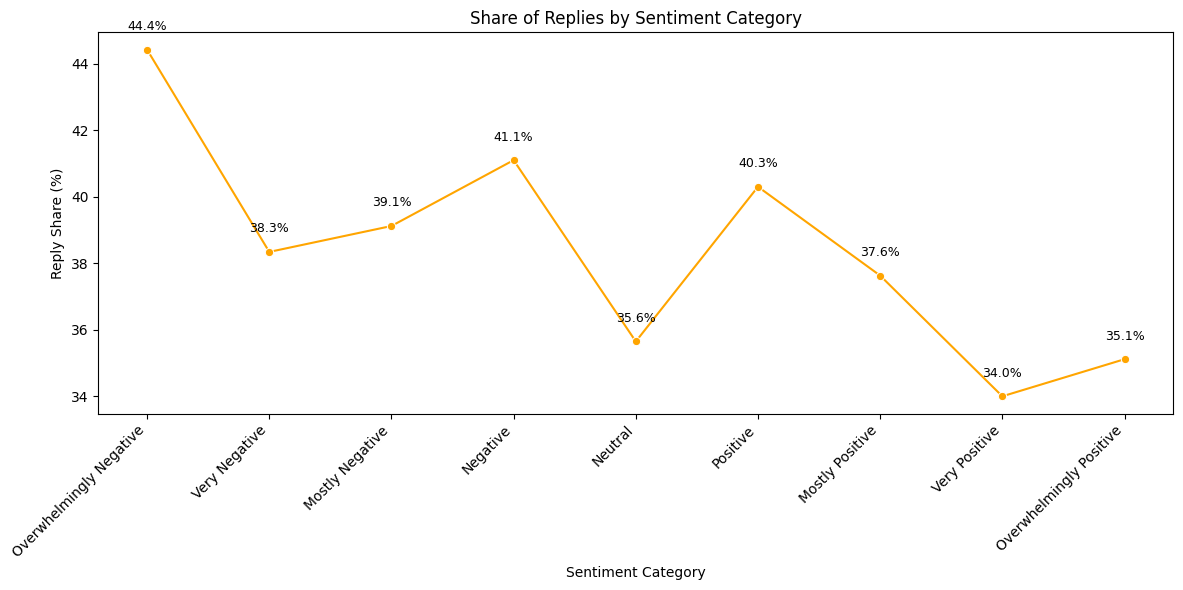

In [8]:
# Calculate total and reply counts per sentiment category
total_counts = df.groupby('sentiment_category', observed=True).size()
reply_counts = df[df['is_reply'] == True].groupby('sentiment_category', observed=True).size()

# Calculate reply share
reply_share = (reply_counts / total_counts * 100).reindex(labels).fillna(0)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=reply_share.index, y=reply_share.values, marker='o', color='orange')

# Add value labels to each point
for i, (x, y) in enumerate(zip(reply_share.index, reply_share.values)):
    ax.text(x, y + 0.5, f"{y:.1f}%", ha='center', va='bottom', fontsize=9, color='black')

plt.title('Share of Replies by Sentiment Category')
plt.ylabel('Reply Share (%)')
plt.xlabel('Sentiment Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Average number of replies by top level comment per sentiment classification
Now, when filtering only top level comments and averaging the number of replies for each sentiment category, the evidence of engagement of comments that talk about negative comments is more pronounced. NOTE: here we are accounting for the sentiment score of the top level comment, not from the replies of this comment.

When the top level comment has a sentiment classification of neutral, it tends to have the least average of replies.

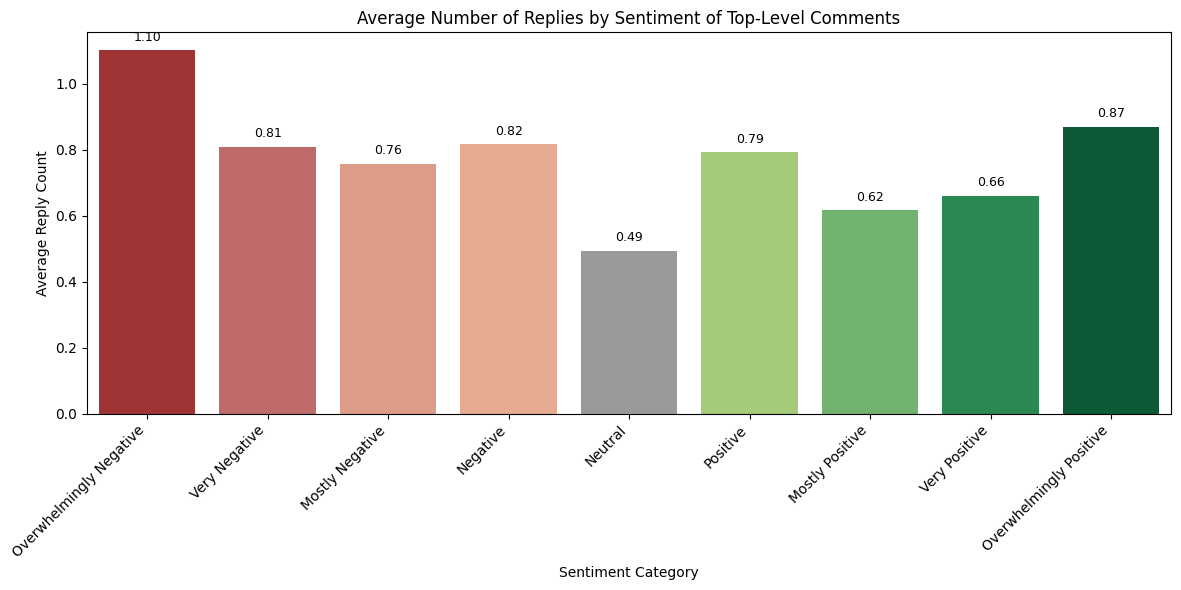

In [9]:
# Filter top-level comments only
top_level = df[df['is_reply'] == False].copy()

# Bin sentiment scores
top_level['sentiment_category'] = pd.cut(
    top_level['sentiment_score'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Group by sentiment category and compute average reply count
avg_replies = top_level.groupby('sentiment_category', observed=True)['reply_count'].mean().reindex(labels)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=avg_replies.index, y=avg_replies.values, palette=color_map, hue=avg_replies.index, legend=False)

plt.title("Average Number of Replies by Sentiment of Top-Level Comments")
plt.xlabel("Sentiment Category")
plt.ylabel("Average Reply Count")
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, value in enumerate(avg_replies.values):
    ax.text(i, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Normalized share of top level comments by reply presence

Now it is more evident why some of the top level comments have an average number of replies of less than one, most of the top level comments don't get a reply at all.

Overwhelmingly negative comments get a higher average of replies due to the nature of overwhelmingly negative comments, we say previously that they were a very little share of
all comments.

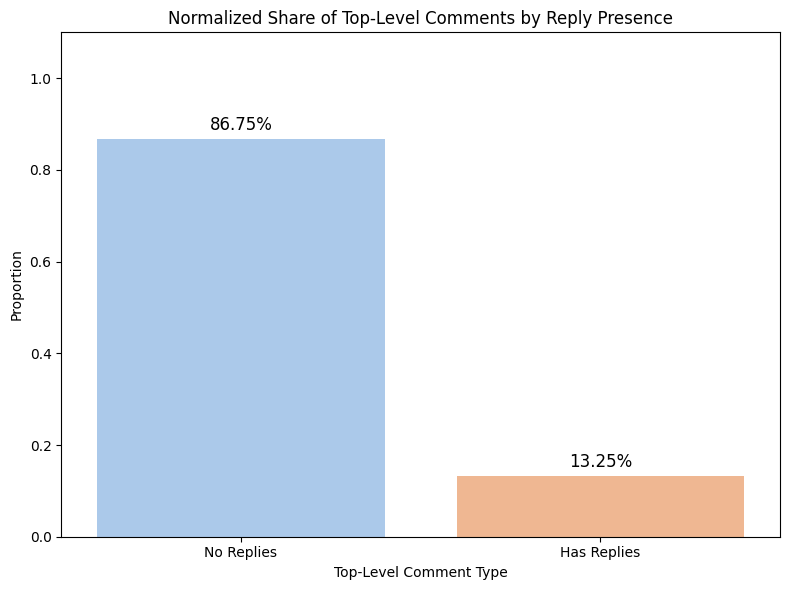

In [14]:
# Filter and copy top-level comments
top_level = df[df['is_reply'] == False].copy()
top_level['has_reply'] = top_level['reply_count'] > 0

# Compute normalized counts
reply_group = top_level['has_reply'].value_counts(normalize=True).sort_index()
plot_df = pd.DataFrame({
    'Reply Status': ['No Replies', 'Has Replies'],
    'Proportion': [reply_group.get(False, 0), reply_group.get(True, 0)]
})

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=plot_df, x='Reply Status', y='Proportion', palette='pastel', hue = 'Reply Status')

# Add percentage labels
for i, v in enumerate(plot_df['Proportion']):
    ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontsize=12)

plt.title("Normalized Share of Top-Level Comments by Reply Presence")
plt.ylabel("Proportion")
plt.xlabel("Top-Level Comment Type")
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

### Normalized distribution of top level comments by sentiment category
Top level comments behave very similarly to the total comments.

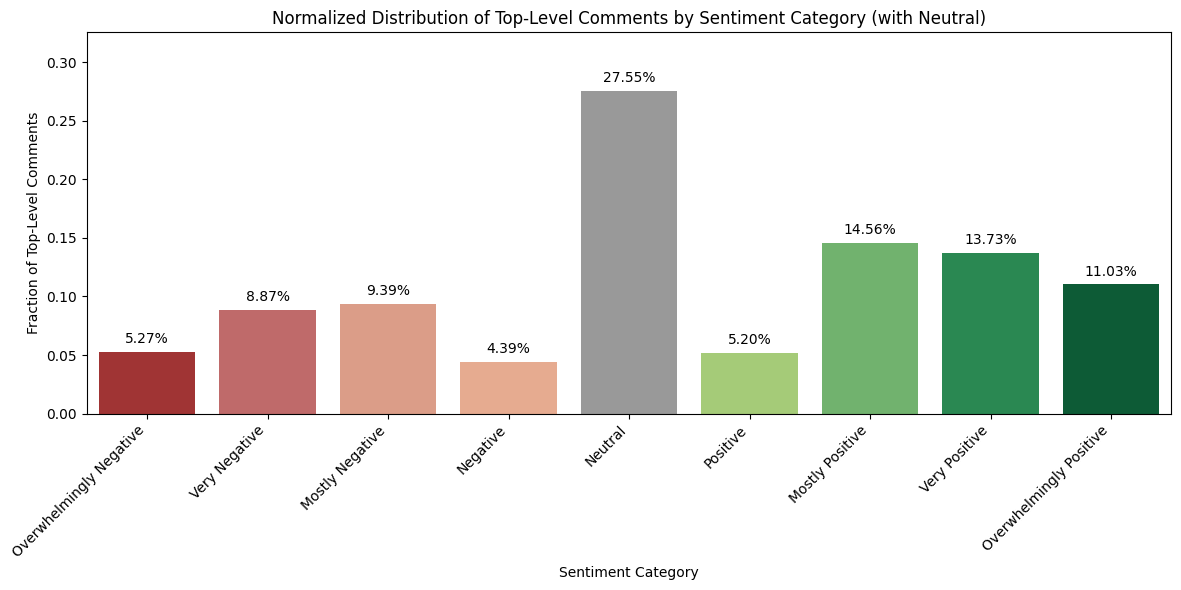

In [ ]:
top_level = df[df['is_reply'] == False].copy()

top_level['sentiment_category'] = pd.cut(
    top_level['sentiment_score'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Normalized counts
cat_counts = top_level['sentiment_category'].value_counts(normalize=True).reindex(labels)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=cat_counts.index,
    y=cat_counts.values,
    hue=cat_counts.index,
    palette=color_map,
    legend=False
)

# Add value labels
for i, val in enumerate(cat_counts.values):
    plt.text(i, val + 0.005, f"{val:.2%}", ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.title("Normalized Distribution of Top-Level Comments by Sentiment Category")
plt.ylabel("Fraction of Top-Level Comments")
plt.xlabel("Sentiment Category")
plt.ylim(0, max(cat_counts.values) + 0.05)
plt.tight_layout()
plt.show()

### Normalized distribution of reply count, filtering out the top .5%

Now let's see the reply behavior of every top level comment.

Not weird that the reply count > 1 is very small compared to zero, although a small decrease in the count of replies is noticed.

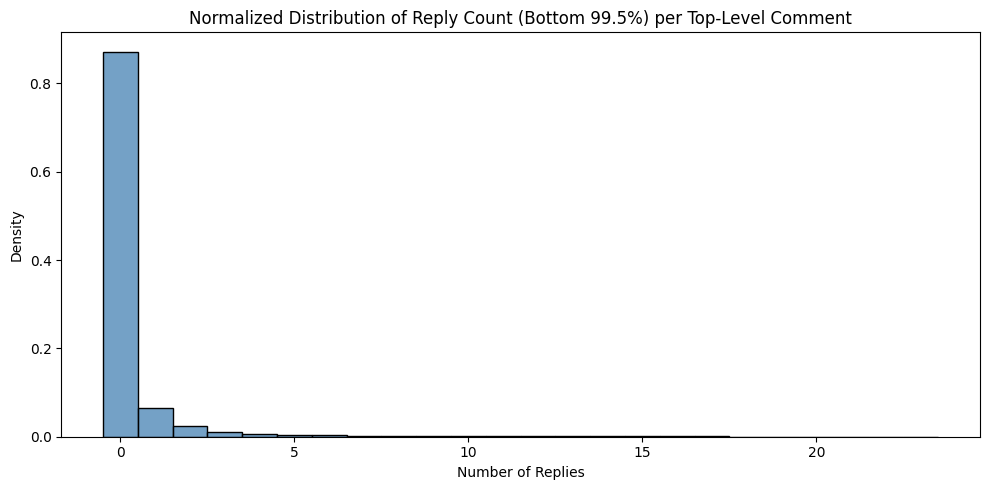

In [ ]:
top_level = df[df['is_reply'] == False].copy()

# Keep bottom 99.5% of reply_count
threshold = np.percentile(top_level['reply_count'], 99.5)
clipped = top_level[top_level['reply_count'] <= threshold]

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(
    clipped['reply_count'], 
    bins=range(0, int(threshold) + 2), 
    stat='density', 
    discrete=True, 
    color='steelblue'
)

plt.title('Normalized Distribution of Reply Count (Bottom 99.5%) per Top-Level Comment')
plt.xlabel('Number of Replies')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Distribution of reply count per top level comment, log
When we log the axis of replies count, the decrease is more evident, showing a steady (but close to exponential) decrease in replies count.

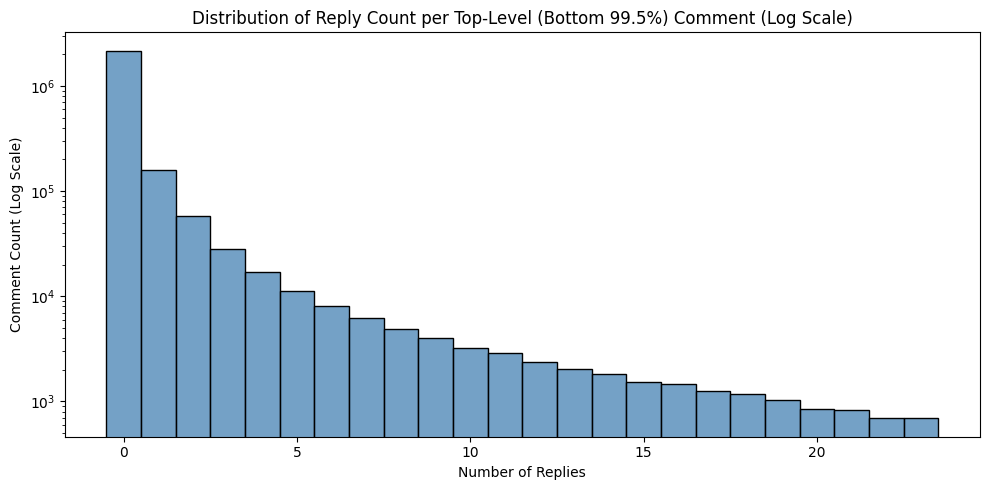

In [11]:
# Filter top-level comments
top_level = df[df['is_reply'] == False].copy()

# Optional: clip extreme outliers (optional but recommended)
threshold = np.percentile(top_level['reply_count'], 99.5)
clipped = top_level[top_level['reply_count'] <= threshold]

# Plot with log scale
plt.figure(figsize=(10, 5))
sns.histplot(
    clipped['reply_count'],
    bins=range(0, int(threshold) + 2),
    stat='count',             # using count here makes more sense with log
    discrete=True,
    color='steelblue'
)

plt.yscale('log')
plt.title('Distribution of Reply Count per Top-Level (Bottom 99.5%) Comment (Log Scale)')
plt.xlabel('Number of Replies')
plt.ylabel('Comment Count (Log Scale)')
plt.tight_layout()
plt.show()


### Reply count per sentiment category, Log
Now a similar graph to the previous ones but distinguishing between sentiment category (or trying to).

The decreasing trend of reply count per sentiment category is somewhat similar across all sentiment categories. It tends to vary somewhat as the reply count increases.

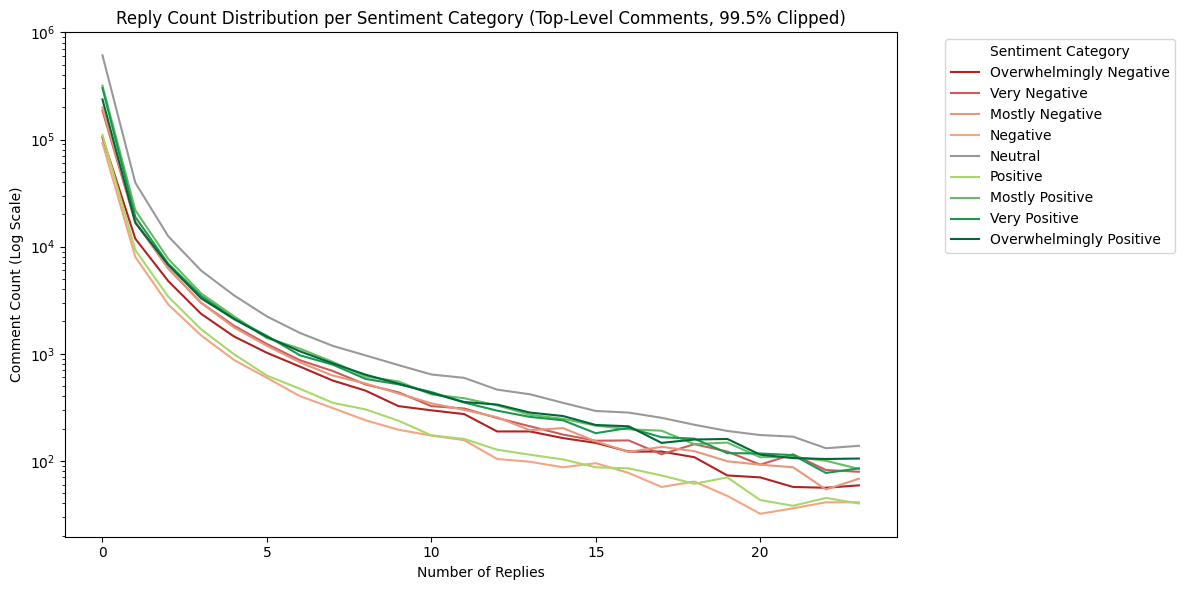

In [16]:
# Filter top-level comments
top_level = df[df['is_reply'] == False].copy()

# Optional: clip extreme outliers (top 0.5% of reply_count)
threshold = np.percentile(top_level['reply_count'], 99.5)
clipped = top_level[top_level['reply_count'] <= threshold]

# Group by reply_count and sentiment_category
grouped = (
    clipped
    .groupby(['reply_count', 'sentiment_category'], observed=True)
    .size()
    .reset_index(name='count')
)

# Pivot so each sentiment_category becomes a column
pivot = grouped.pivot(index='reply_count', columns='sentiment_category', values='count').fillna(0)

# Plot
plt.figure(figsize=(12, 6))

# Ensure the sentiment categories are plotted in a consistent order (optional but cleaner)
sentiment_order = [
    "Overwhelmingly Negative", "Very Negative", "Mostly Negative", "Negative", 
    "Neutral", "Positive", "Mostly Positive", "Very Positive", "Overwhelmingly Positive"
]

# Loop through the ordered categories
for category in sentiment_order:
    if category in pivot.columns:
        plt.plot(
            pivot.index,
            pivot[category],
            label=category,
            color=color_map.get(category, "#333333")  # fallback color
        )

# Log scale and labels
plt.yscale('log')
plt.xlabel('Number of Replies')
plt.ylabel('Comment Count (Log Scale)')
plt.title('Reply Count Distribution per Sentiment Category (Top-Level Comments, 99.5% Clipped)')

# Legend
plt.legend(title='Sentiment Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Layout and show
plt.tight_layout()
plt.show()

# Proportion of top level comments with >0 replies per sentiment category
When we observe more closely the top level comments that did get at least one reply, comments with a negative sentiment score have a higher share, and almost twice that of
top level comments with at least one reply classified as neutral.

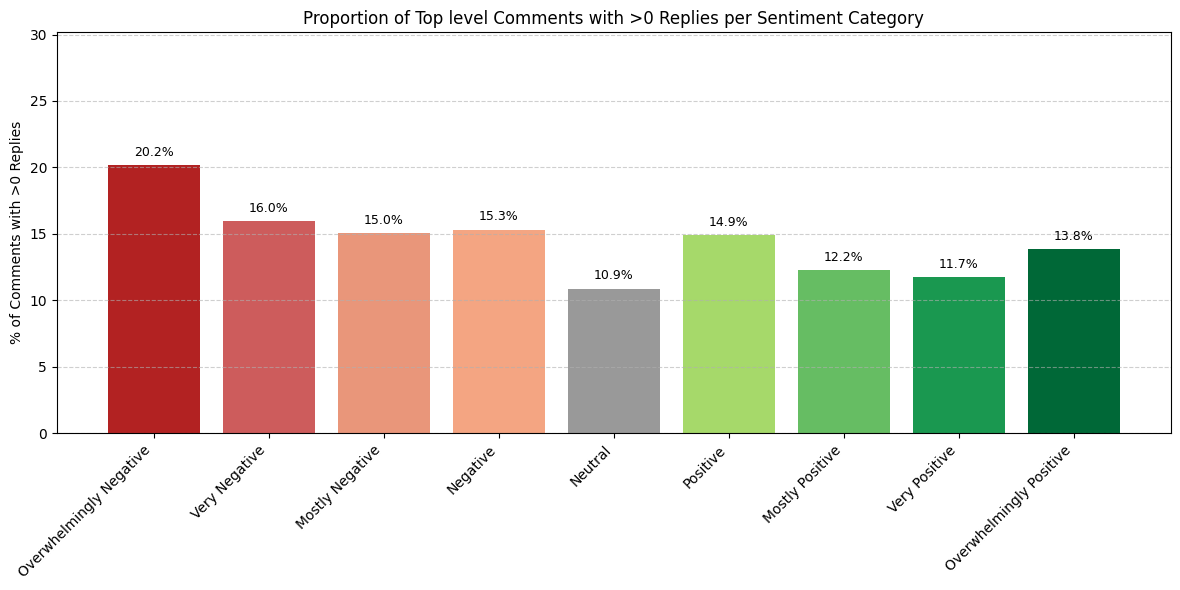

In [ ]:
# Filter top-level comments
top_level = df[df['is_reply'] == False].copy()

# Create binary reply type
top_level['reply_type'] = np.where(top_level['reply_count'] == 0, '0 replies', '>0 replies')

# Group by reply_type and sentiment_category
grouped = (
    top_level
    .groupby(['reply_type', 'sentiment_category'], observed=True)
    .size()
    .unstack(fill_value=0)
    .loc[['0 replies', '>0 replies']]  # Ensures correct row order
)

# Normalize column-wise (get % of >0 replies per sentiment)
percentages = grouped.div(grouped.sum(axis=0), axis=1) * 100
share_over_zero = percentages.loc['>0 replies'][sentiment_order]

# Plot as a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(
    share_over_zero.index,
    share_over_zero.values,
    color=[color_map.get(cat, '#333333') for cat in share_over_zero.index]
)

# Annotate bars with percentage labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Formatting
plt.ylabel('% of Comments with >0 Replies')
plt.title('Proportion of Top level Comments with >0 Replies per Sentiment Category')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(share_over_zero) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Likelihood of getting at least 1 reply vs. Neutral sentiment
We now check the engagement level per sentiment category. It is a similar to the previous one but we take the neutral category as a baseline. How large is the proportion of replies VS neutral top level comment FOR TOP LEVEL COMMENTS THAT HAVE AT LEAST ONE REPLY.

A better indicator of engagement can be drawn from "Average number of replies by top level comment per sentiment classification", since that one includes top level comments without replies.

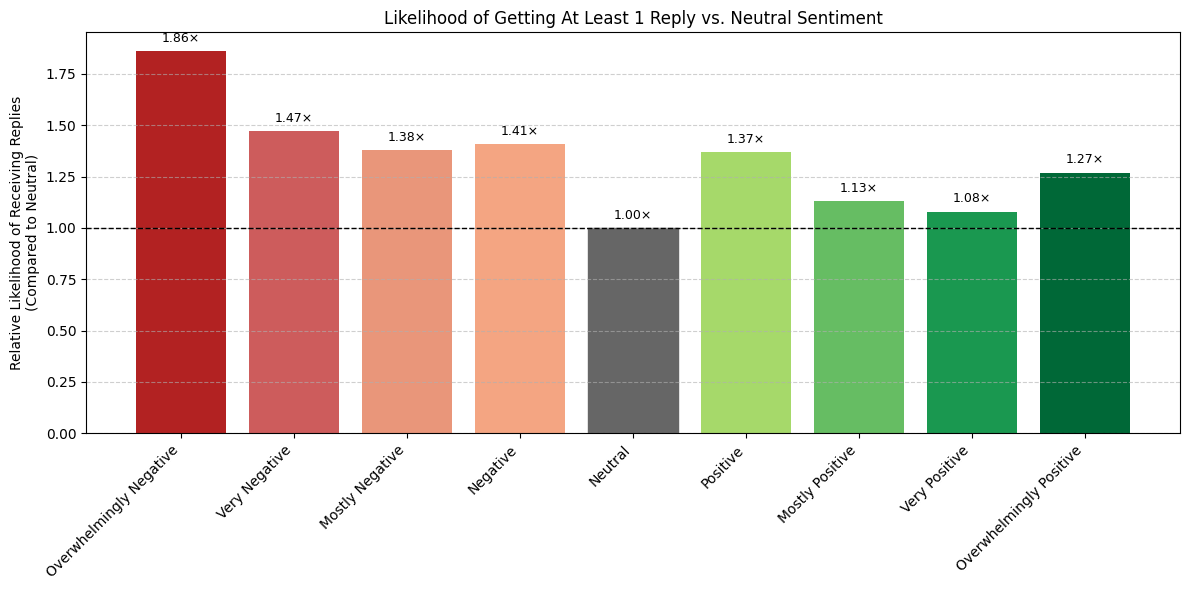

In [ ]:
# Assuming `share_over_zero` is a pandas Series like the one above:
neutral_rate = share_over_zero["Neutral"]

relative_risk = share_over_zero / neutral_rate
relative_risk = relative_risk.round(2)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    relative_risk.index,
    relative_risk.values,
    color=[color_map.get(cat, '#333333') for cat in relative_risk.index]
)

# Highlight neutral as baseline
bars[relative_risk.index.get_loc("Neutral")].set_color("#666666")  # darker gray for neutral

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.03,
        f'{height:.2f}×',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Formatting
plt.axhline(1, color='black', linestyle='--', linewidth=1)
plt.ylabel('Relative Likelihood of Receiving Replies\n(Compared to Neutral)')
plt.title('Likelihood of Getting At Least 1 Reply vs. Neutral Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()